In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet

2025-11-19 17:41:57.000671: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 17:41:57.493263: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-19 17:41:59.278030: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Importing plotly failed. Interactive plots will not work.


In [ ]:
df = pd.read_csv("synthetic_load_with_missing.csv")



In [30]:
df.rename(columns={"Unnamed: 0": "Timestamp"}, inplace=True)

df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")


In [ ]:
df = df.sort_values("Timestamp")
df = df.set_index("Timestamp")

In [32]:
df['load'] = df['load'].interpolate(method='time')

In [33]:
last_date = df.index.max()
test_start = last_date - pd.Timedelta(days=7)

train_df = df[df.index < test_start]
test_df  = df[df.index >= test_start]

print("Train size:", train_df.shape)
print("Test size :", test_df.shape)

Train size: (17351, 7)
Test size : (169, 7)


In [69]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['load']])
test_scaled  = scaler.transform(test_df[['load']])

def create_sequences(data, steps=24):
    X, y = [], []
    for i in range(steps, len(data)):
        X.append(data[i-steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lookback = 24
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test   = create_sequences(test_scaled, lookback)

In [70]:
model = Sequential()
model.add(LSTM(64, activation="tanh", return_sequences=False, input_shape=(lookback, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [71]:
print("Training LSTM...")
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


Training LSTM...
Epoch 1/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0062
Epoch 2/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0017
Epoch 3/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0016
Epoch 4/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0016
Epoch 5/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0015
Epoch 6/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0015
Epoch 7/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0015
Epoch 8/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0015
Epoch 9/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0015
Epoch 10/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0015
Epoch 11/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0015
Epoch 12/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0015
Epoch 13/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0015
Epoch 14/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0014
Epoch 15/20
542/542 ━━━━━━━━━━━━━━━━━━━━

In [72]:
lstm_pred_scaled = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [ ]:
df_prophet = train_df.reset_index()

df_prophet = df_prophet.rename(columns={
    df_prophet.columns[0]: 'ds', 
    'load': 'y'
})

# Keep only ds and y
df_prophet = df_prophet[['ds', 'y']]

In [74]:
m = Prophet()
m.fit(df_prophet)


18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
future = test_df.reset_index().rename(columns={'Timestamp':'ds'})
forecast = m.predict(future)

prophet_pred = forecast['yhat'].values

In [76]:
hybrid_pred = (lstm_pred.flatten() + prophet_pred[lookback:]) / 2

In [77]:

actual = test_df['load'].values[lookback:]

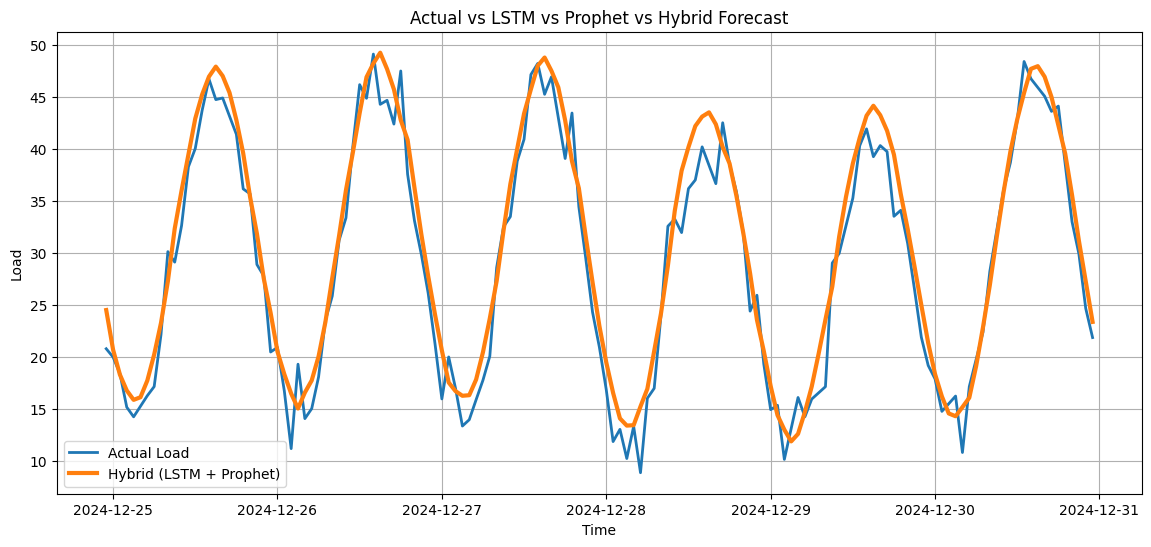

In [78]:
plt.figure(figsize=(14,6))
plt.plot(test_df.index[lookback:], actual, label="Actual Load", linewidth=2)
plt.plot(test_df.index[lookback:], hybrid_pred, label="Hybrid (LSTM + Prophet)", linewidth=3)

plt.xlabel("Time")
plt.ylabel("Load")
plt.title("Actual vs LSTM vs Prophet vs Hybrid Forecast")
plt.legend()
plt.grid(True)
plt.show()

In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [80]:
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(actual, hybrid_pred)
rmse = mean_squared_error(actual, hybrid_pred, squared=False)
mape_value = mape(actual, hybrid_pred)

print("===== HYBRID MODEL PERFORMANCE =====")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape_value:.2f}%")

===== HYBRID MODEL PERFORMANCE =====
MAE  : 2.2398
RMSE : 2.6885
MAPE : 9.62%


In [ ]:
results = pd.DataFrame({
    "timestamp": test_df.index[-len(actual):],
    "actual_load": actual,
    "hybrid_pred": hybrid_pred
})

results.to_csv("last_7_days_predictions.csv", index=False)

print("File saved: last_7_days_predictions.csv")


File saved: last_7_days_predictions.csv


In [84]:
import pickle

In [95]:
model.save("lstm_model.h5")
print("LSTM model saved as lstm_model.h5")


LSTM model saved as lstm_model.h5


In [ ]:
import pickle


with open("prophet_model.pkl", "wb") as f:
    pickle.dump(m, f)


lstm_json = model.to_json()           # LSTM architecture
lstm_weights = model.get_weights()    # LSTM weights


hybrid_package = {
    "prophet_path": "prophet_model.pkl",
    "lstm_json": lstm_json,
    "lstm_weights": lstm_weights,
    "lookback": lookback,
    "scaler": scaler
}

with open("hybrid.pkl", "wb") as f:
    pickle.dump(hybrid_package, f)

print("Hybrid model saved successfully → hybrid.pkl")


Hybrid model saved successfully → hybrid.pkl


In [107]:
import pickle

with open("hybrid.pkl", "rb") as f:
    hybrid = pickle.load(f)

print("Keys inside hybrid.pkl:", hybrid.keys())


Keys inside hybrid.pkl: dict_keys(['prophet_path', 'lstm_json', 'lstm_weights', 'lookback', 'scaler'])


In [ ]:
import pickle
import numpy as np
import pandas as pd
from prophet import Prophet
from tensorflow.keras.models import model_from_json



with open("hybrid.pkl", "rb") as f:
    hybrid = pickle.load(f)

prophet_path = hybrid["prophet_path"]
lstm_json = hybrid["lstm_json"]
lstm_weights = hybrid["lstm_weights"]
lookback = hybrid["lookback"]
scaler = hybrid["scaler"]

print("Hybrid.pkl loaded successfully!")


with open(prophet_path, "rb") as f:
    prophet = pickle.load(f)

print("Prophet model loaded!")



lstm = model_from_json(lstm_json)
lstm.set_weights(lstm_weights)

print("LSTM model rebuilt successfully!")


last_loads = np.array([
    150,152,151,153,155,154,156,158,159,160,
    161,162,163,164,165,166,167,168,169,170,
    171,172,173,174
], dtype=float)

last_loads = last_loads[-lookback:]

scaled_last = scaler.transform(last_loads.reshape(-1, 1))
lstm_input = scaled_last.reshape(1, lookback, 1)



lstm_pred_scaled = lstm.predict(lstm_input)
lstm_future = scaler.inverse_transform(lstm_pred_scaled).flatten()



future_df = prophet.make_future_dataframe(periods=48, freq='H')
forecast_df = prophet.predict(future_df)
prophet_future = forecast_df.tail(48)["yhat"].values
prophet_timestamps = forecast_df.tail(48)["ds"].values


hybrid_future = (lstm_future + prophet_future) / 2

result_df = pd.DataFrame({
    "Timestamp": prophet_timestamps,
    "Hybrid_Load": hybrid_future
})

print("\n========== HYBRID FORECAST (Next 48 Hours) ==========\n")
print(result_df.to_string(index=False))


Hybrid.pkl loaded successfully!
Prophet model loaded!
LSTM model rebuilt successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



========== HYBRID FORECAST (Next 48 Hours) ==========

          Timestamp  Hybrid_Load
2024-12-23 23:00:00    88.919900
2024-12-24 00:00:00    87.336758
2024-12-24 01:00:00    86.072332
2024-12-24 02:00:00    85.229218
2024-12-24 03:00:00    84.906246
2024-12-24 04:00:00    85.165855
2024-12-24 05:00:00    86.005859
2024-12-24 06:00:00    87.353674
2024-12-24 07:00:00    89.085340
2024-12-24 08:00:00    91.055767
2024-12-24 09:00:00    93.122614
2024-12-24 10:00:00    95.155243
2024-12-24 11:00:00    97.032748
2024-12-24 12:00:00    98.640865
2024-12-24 13:00:00    99.874144
2024-12-24 14:00:00   100.643193
2024-12-24 15:00:00   100.883833
2024-12-24 16:00:00   100.566489
2024-12-24 17:00:00    99.705458
2024-12-24 18:00:00    98.365282
2024-12-24 19:00:00    96.657928
2024-12-24 20:00:00    94.726025
2024-12-24 21:00:00    92.715878
2024-12-24 22:00:00    90.753466
2024-12-24 23:00:00    88.937454
2024-12-25 00:00:00    87.352050
2024-12-25 01:00:00    86.086885
2024-12-25 02:00:00 